In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import salamander

In [2]:
counts_sbs = pd.read_csv("data/pcawg_breast_sbs.csv", index_col=0)

## NMF with KL-divergence loss

In [3]:
n_signatures = 6

model = salamander.KLNMF(
    n_signatures=n_signatures,
    max_iterations=500
)
model.fit(counts_sbs)

The fitted signatures and exposures of all NMF models can be accessed via $\texttt{model.signatures}$ and $\texttt{model.exposures}$ respecively:

In [4]:
model.signatures.head()

,Sig1,Sig2,Sig3,Sig4,Sig5,Sig6
A[C>A]A,0.001238,0.025333,1.260770e-07,4.489314e-03,0.017713,1.192093e-07
A[C>A]C,0.000672,0.020666,1.192093e-07,3.499727e-03,0.011037,1.192093e-07
A[C>A]G,0.000127,0.003056,2.668608e-06,2.644821e-07,0.002036,2.465387e-03
A[C>A]T,0.000712,0.021227,2.174860e-07,4.240899e-03,0.005041,1.192093e-07
C[C>A]A,0.001610,0.021114,1.192655e-07,5.148172e-03,0.010452,1.192093e-07


In [5]:
model.exposures.head()

,SP9251,SP6730,SP10084,SP5381,SP10635,SP2714,SP11235,SP8085,SP4593,SP4820,...,SP117778,SP117032,SP117710,SP117538,SP124207,SP117800,SP117724,SP124193,SP2766,SP6115
Sig1,3.449979e+02,2.007543e+02,5.623219e+02,0.111964,88.970422,1571.168568,216.508583,491.397130,1.868891e+02,191.187382,...,47.011600,15.042909,5.251338e+02,1.004266e+03,537.530806,380.508304,59.515518,1.004260e+03,3.205625e+02,74.013757
Sig2,3.357166e+03,1.593482e+03,7.368155e+03,450.321678,739.471617,7698.741237,2141.421424,1919.415168,5.692887e+02,5522.179795,...,904.555590,878.972603,6.580696e+02,7.865527e+03,5295.373652,1792.441593,685.949956,4.221822e+02,6.579297e+03,917.240322
Sig3,2.238549e+02,8.172635e+01,6.988822e-02,14.349404,0.007496,1723.181046,126.083146,237.670142,1.192798e-07,105.650397,...,20.306668,62.275359,1.192798e-07,3.471296e+02,9.433533,153.838696,138.294633,1.192798e-07,2.102208e+02,121.391860
Sig4,1.192354e-07,1.442566e-07,1.192354e-07,14.909163,0.000009,0.023695,0.000004,0.001291,1.192354e-07,102.038725,...,13.746514,33.259206,5.853251e+01,7.355592e+01,456.234954,20.731055,27.067187,6.108872e-05,1.192354e-07,0.002848
Sig5,6.832664e+02,2.661421e+03,1.151484e+03,757.358834,1162.034760,0.076948,1541.164656,1543.342674,1.262059e+03,381.991776,...,1550.381589,1128.290912,1.230288e+03,2.090756e-07,1609.928333,1819.383548,1712.581352,1.055936e+03,5.774884e-04,880.310583


All implemented NMF models also come with methods to visualize the signatures, the exposures and the signature and sample correlations:

array([<Axes: title={'center': 'Sig1'}>, <Axes: title={'center': 'Sig2'}>,
       <Axes: title={'center': 'Sig3'}>, <Axes: title={'center': 'Sig4'}>,
       <Axes: title={'center': 'Sig5'}>, <Axes: title={'center': 'Sig6'}>],
      dtype=object)

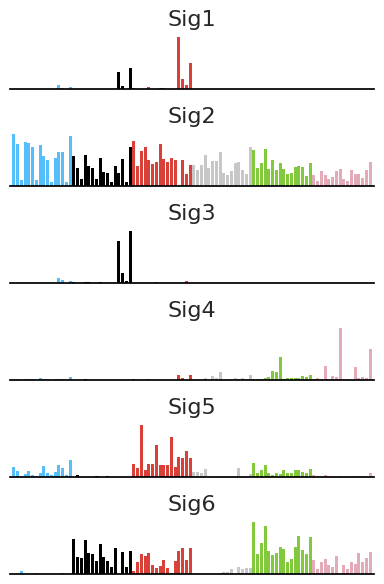

In [6]:
model.plot_signatures()

Like all other plotting methods, $\texttt{plot\_signatures()}$ just wraps around matplotlib and returns the matplotlib axes instances. This makes it effortless to apply custom modifications to the plot. For example, it is possible to rearrange the signature plots to our liking, widen all bars, and change the fontsize:

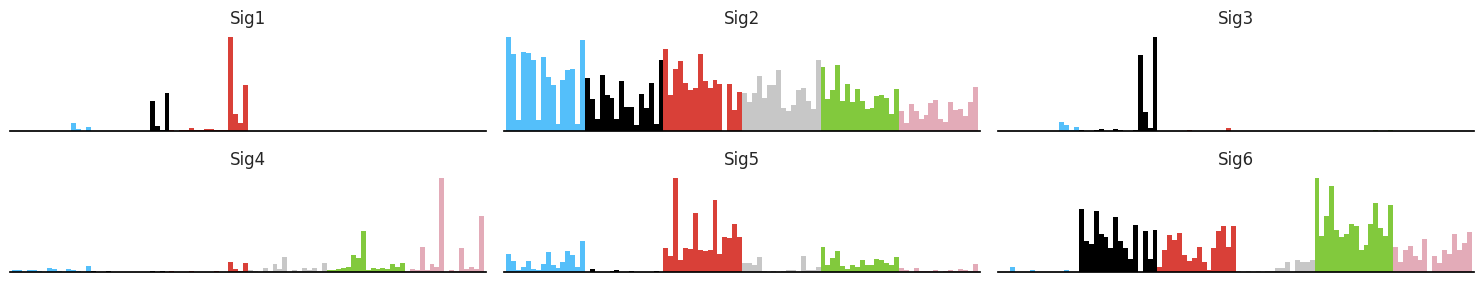

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(15, 3))
axes = model.plot_signatures(axes=axes, width=1)

for ax in axes.flatten():
    ax.set_title(ax.get_title(), fontsize=12)

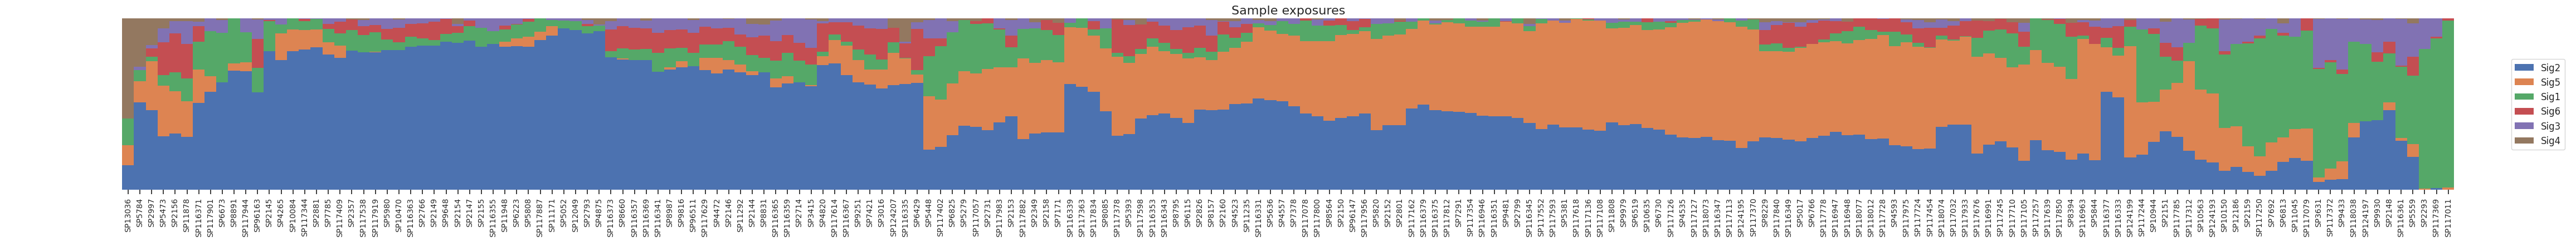

In [8]:
# stacked barplot of the exposures
_ = model.plot_exposures()

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

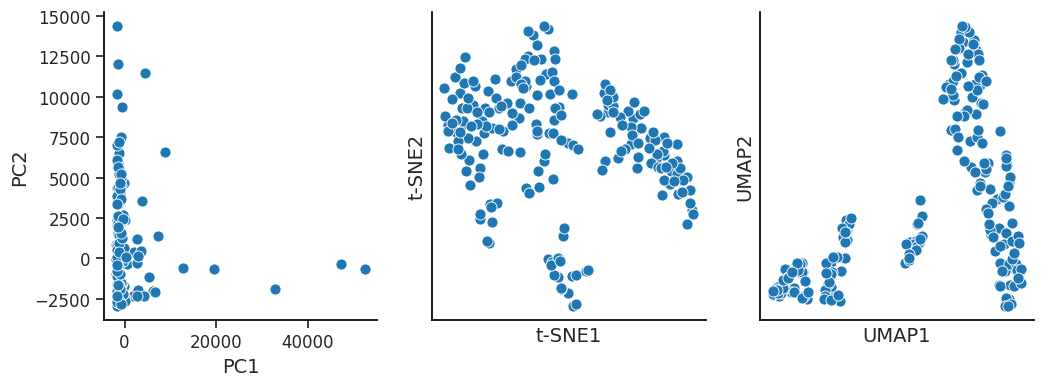

In [9]:
# PCA, t-SNE or UMAP of the sample exposures
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

model.plot_embeddings(method="pca", ax=axes[0])
model.plot_embeddings(method="tsne", ax=axes[1])
model.plot_embeddings(method="umap", ax=axes[2])

Let's say we want to color all samples with a high relative exposure to a certain signature. Again, the UMAP, t-SNE and PCA implementations just wrap around seaborns scatterplot and customizations can be made.

In [10]:
special_signature = "Sig1"
threshold = 0.2

relative_exposures = model.exposures / model.exposures.sum(axis=0)
relative_exposures = relative_exposures.T # signatures as columns
special_samples = relative_exposures.loc[relative_exposures[special_signature] >= threshold].index.to_numpy()

group_labels = [
    "special group" if sample in special_samples else "other"
    for sample in model.sample_names
]

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

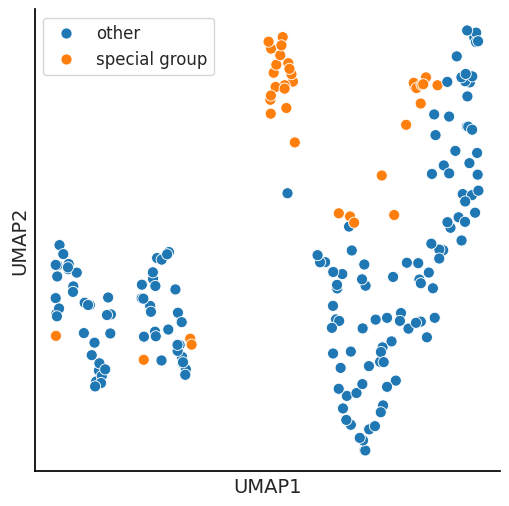

In [11]:
# colored UMAP
model.plot_embeddings(method="umap", hue=group_labels)

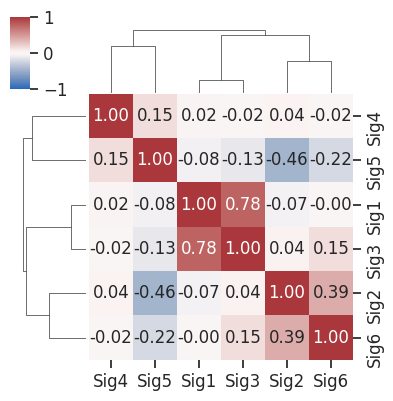

In [12]:
# signature correlations
model.plot_correlation(annot=True, figsize=(4,4))

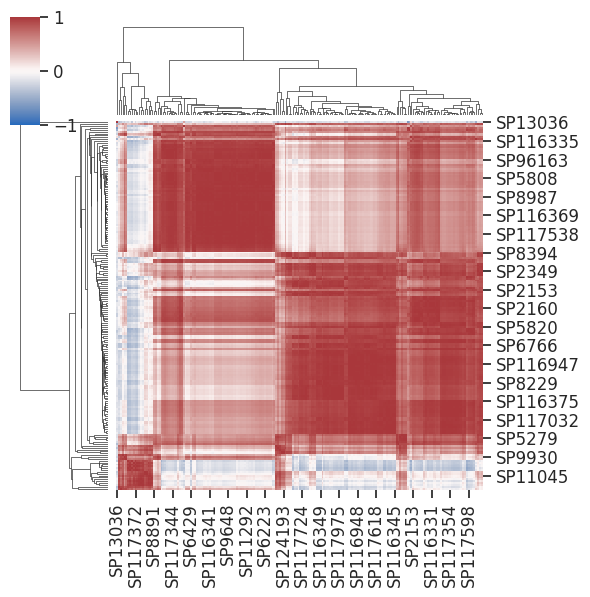

In [13]:
# sample correlations
model.plot_correlation(data="samples")

## Other NMF models

The syntax for minimum volume NMF and correlated NMF is identical. In this tutorial, we only run these models for 3 iterations because of their longer runtime.

In [14]:
# lambda_tilde: volume penalty parameter in the loss function of mvNMF
model_mvnmf = salamander.MvNMF(
    n_signatures=n_signatures,
    lambda_tilde=1,
    max_iterations=3
)
model_mvnmf.fit(counts_sbs)

In [15]:
# dim_embeddings: common embedding dimension of the signatures and samples
model_corrnmf = salamander.CorrNMFDet(
    n_signatures=n_signatures,
    dim_embeddings=n_signatures,
    max_iterations=3
)
model_corrnmf.fit(counts_sbs)

The only difference to the above visualizations with these models is that the embedding plots of CorrNMF show the signature embeddings as well.

## Multimodal correlated NMF

Multimodal correlated NMF can process multiple data modalities at once assuming the input data for each modality originates from the identical samples.

In [16]:
counts_indel = pd.read_csv("data/pcawg_breast_indel.csv", index_col=0)
n_features_indel = len(counts_indel.index)

# 196 samples with single base substitution data, a subset of 192 samples have indel data
counts_sbs = counts_sbs[counts_indel.columns]
n_features_sbs = len(counts_sbs.index)

In [17]:
counts_sbs = 10 * n_features_sbs * counts_sbs / counts_sbs.sum(axis=0)
counts_indel = 10 * n_features_indel * counts_indel / counts_indel.sum(axis=0)

In [18]:
multi_model = salamander.MultimodalCorrNMF(
    n_modalities=2,
    ns_signatures=[7, 5],
    dim_embeddings=5,
    min_iterations=50,
    max_iterations=50
)
multi_model.fit(data=[counts_sbs, counts_indel], history=True)

The above cell should take about ten seconds to execute. We can examine the convergence of the algorithm by checking the history of the objective function.

**Important note**: The number of iterations specified above is insufficient and the obtained signatures are nonsensical. This tutorial only focuses on the usage of the package, not on any results.

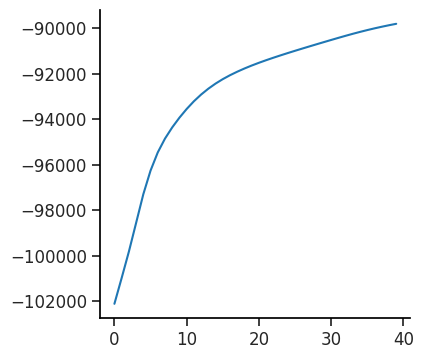

In [19]:
history = multi_model.history["objective_function"]

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(np.arange(len(history[10:])), history[10:])

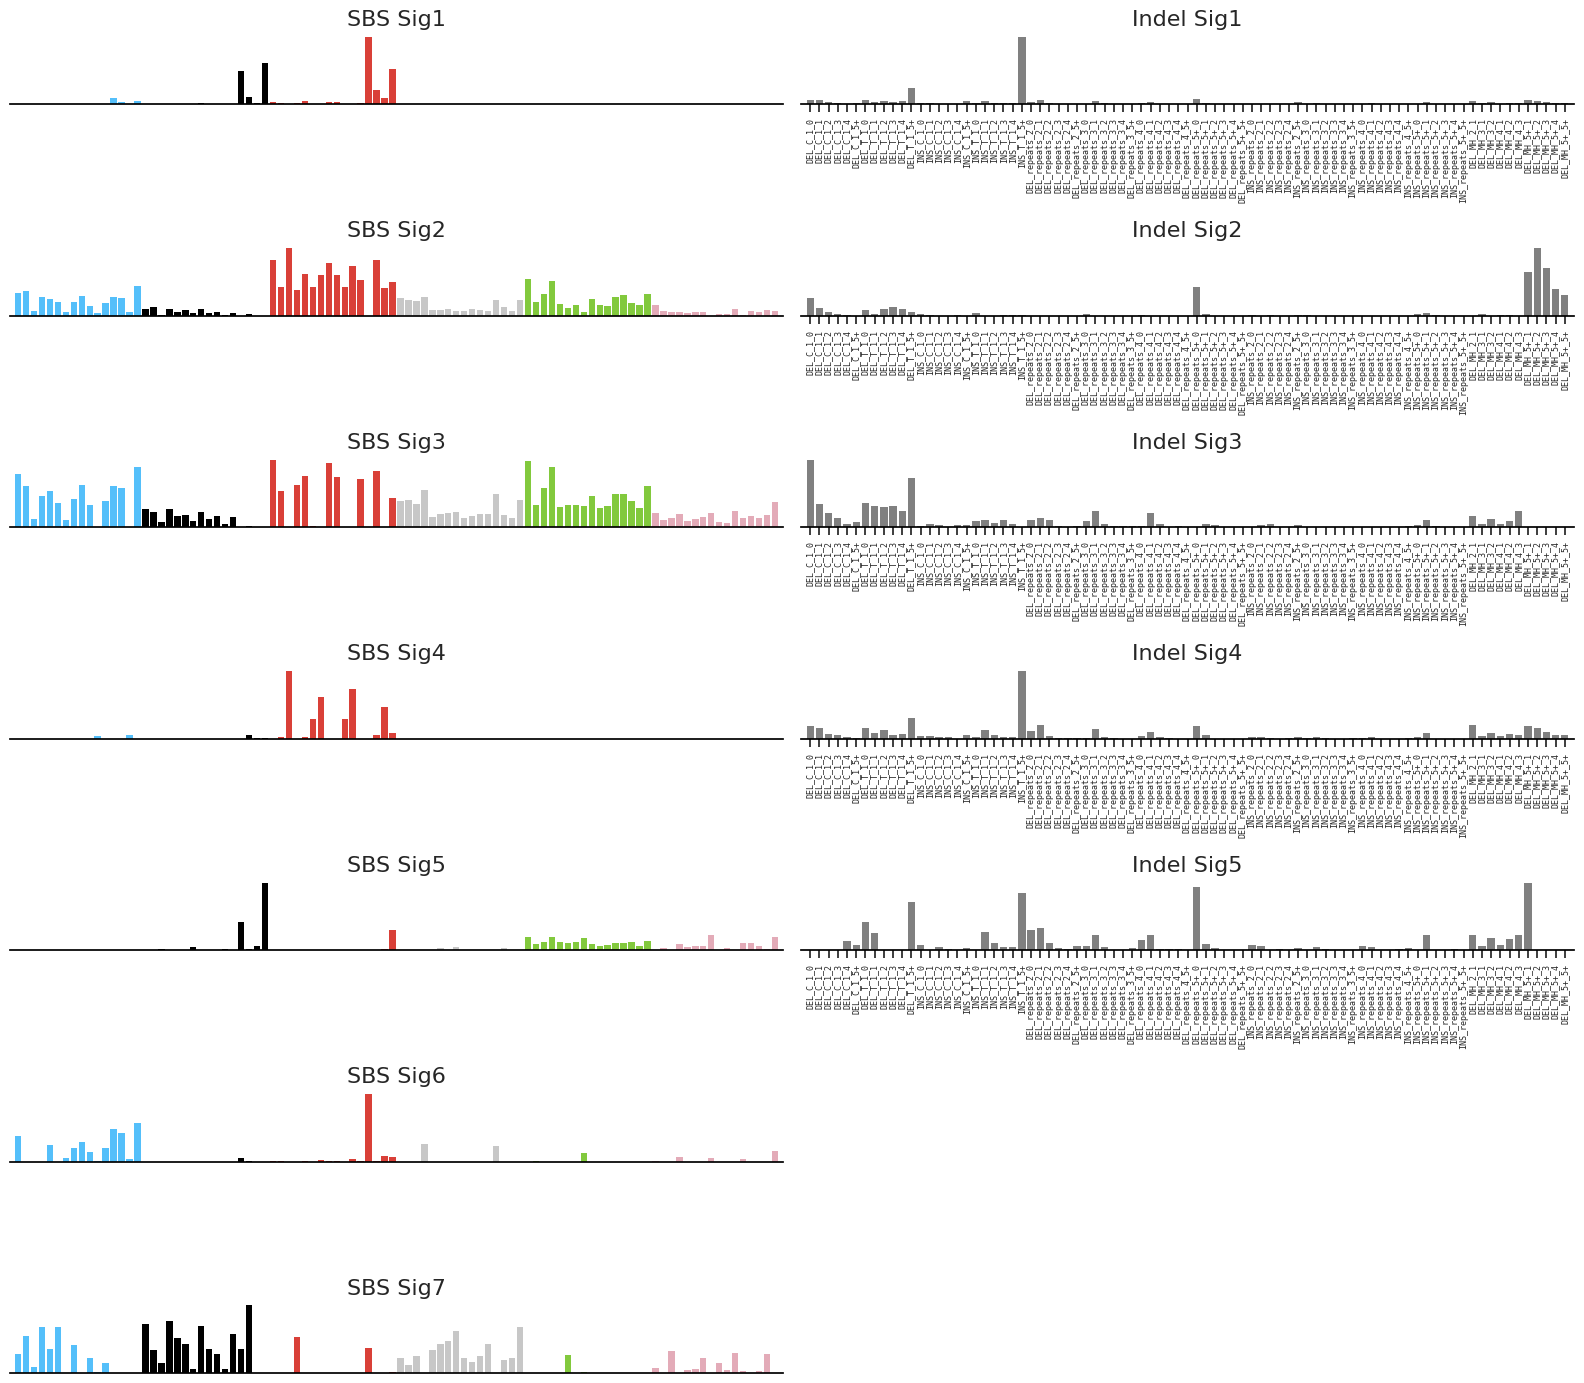

In [20]:
axes = multi_model.plot_signatures(annotate_mutation_types=True)

# remove mutation type annotations for the SBS signatures
for ax in axes[:,0]:
    ax.set_xticks([])

for ax in axes.flatten():
    ax.tick_params(axis="x", which="major", labelsize=6)

plt.tight_layout()

array([<Axes: title={'center': 'SBS signature exposures'}>,
       <Axes: title={'center': 'Indel signature exposures'}>],
      dtype=object)

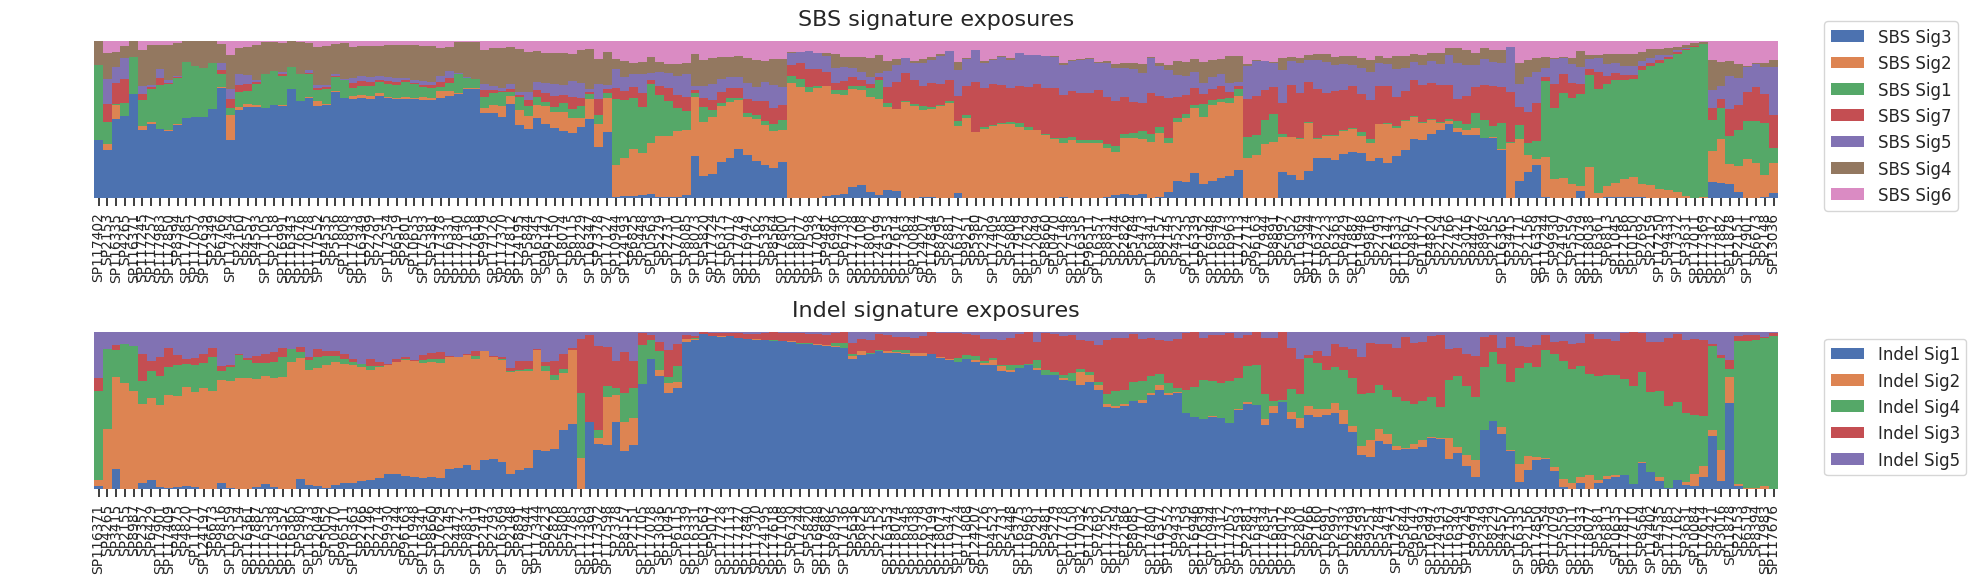

In [21]:
# exposures for each data modalities. Note: the samples are ordered per modality
multi_model.plot_exposures()

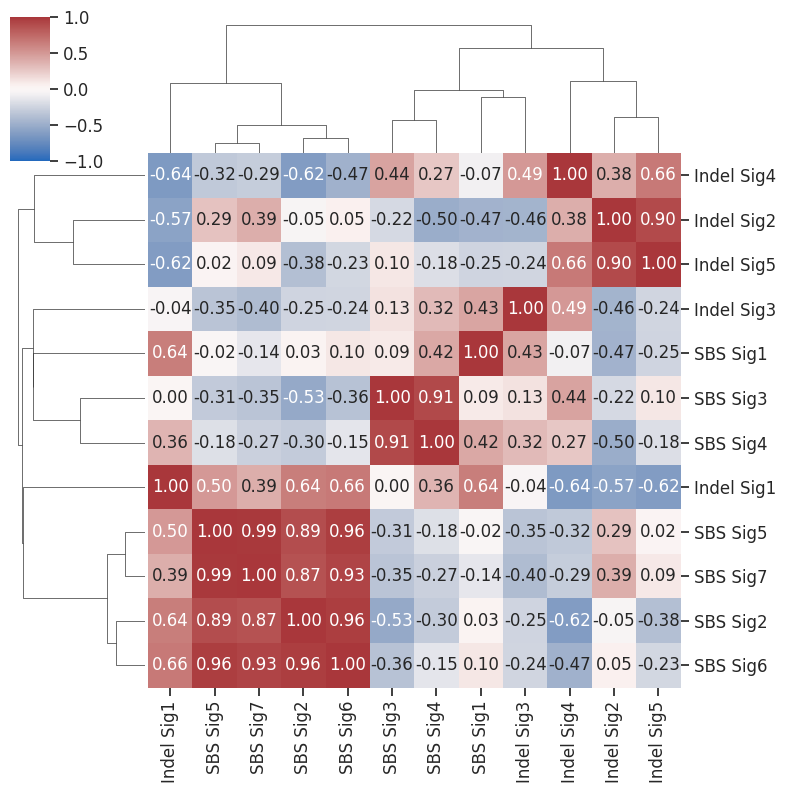

In [22]:
multi_model.plot_correlation(figsize=(8, 8), annot=True)

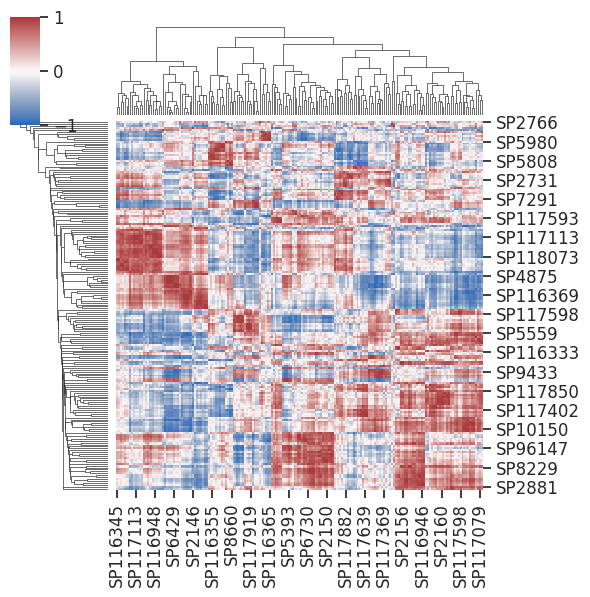

In [23]:
multi_model.plot_correlation(data="samples")

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

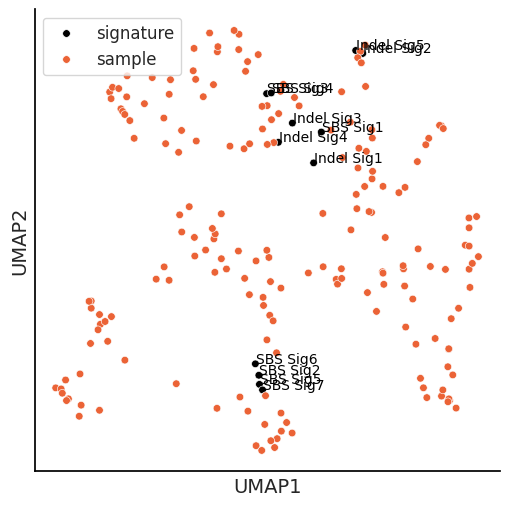

In [24]:
palette = [(0, 0, 0), (0.92, 0.39, 0.21)]
hue = np.sum(multi_model.ns_signatures) * ["signature"] + multi_model.n_samples * ["sample"]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
multi_model.plot_embeddings(
    method="umap",
    hue=hue,
    palette=palette,
    s=30,
    annotation_kwargs={"fontsize": 10},
    ax=ax
)

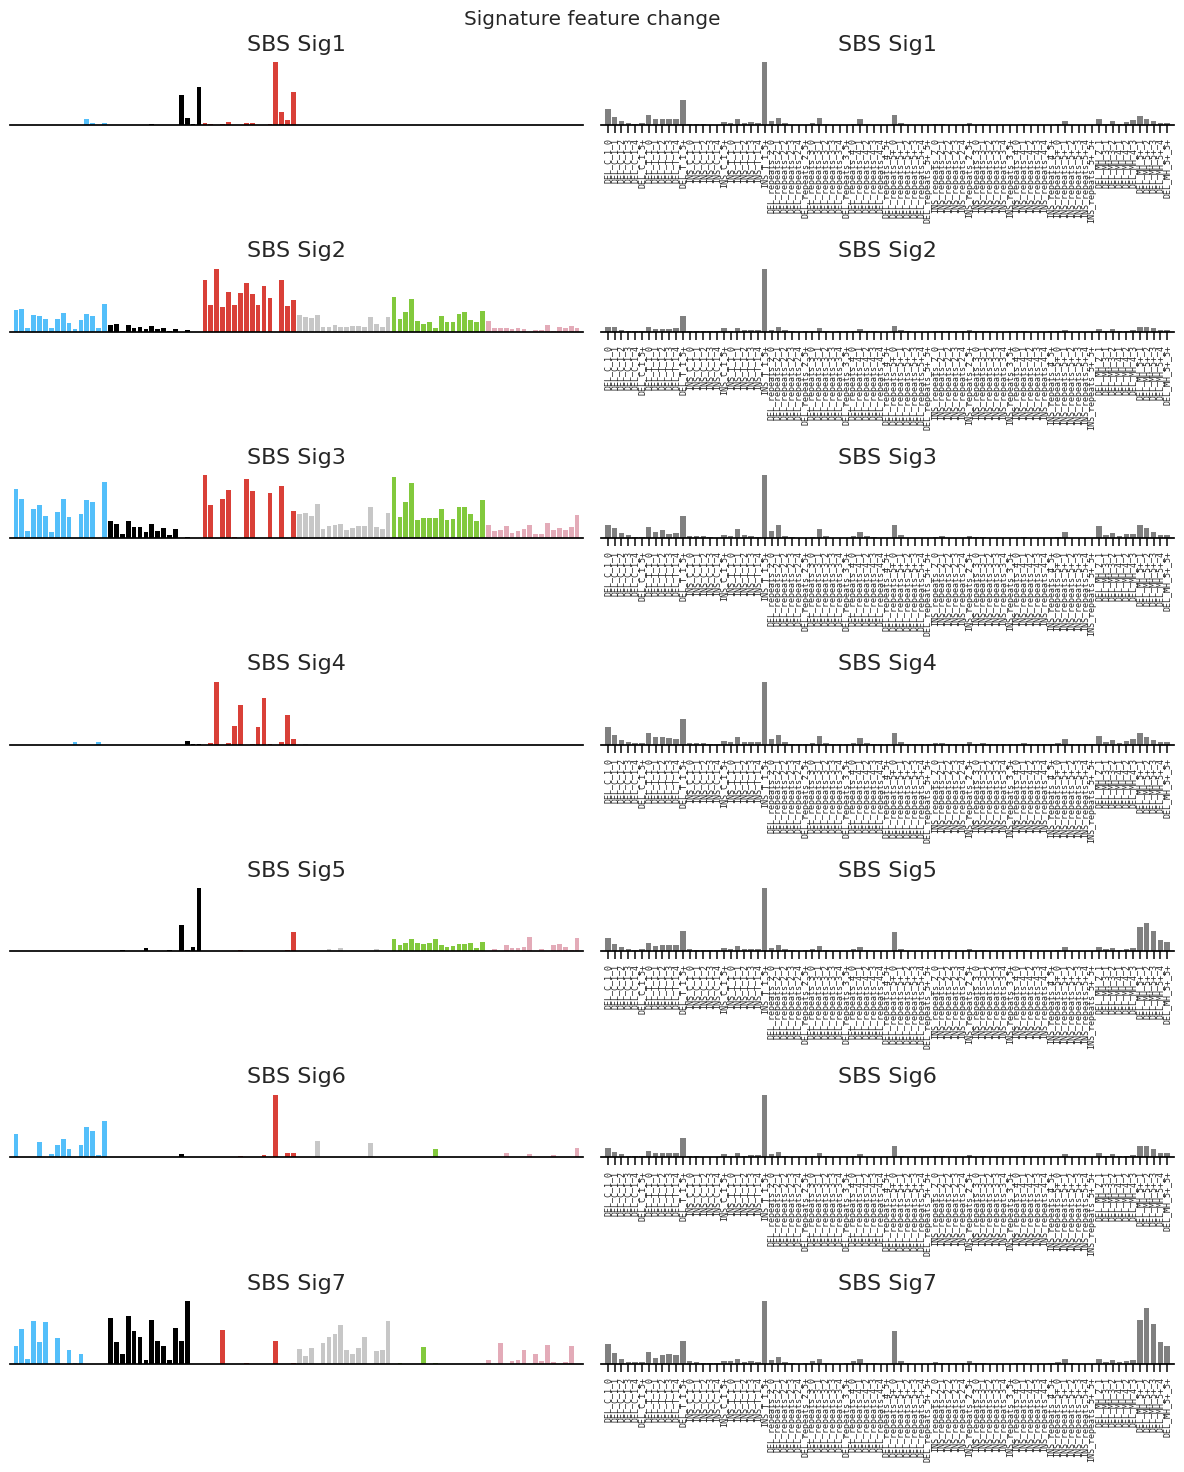

In [25]:
# co-occuring Indel spectrum for all SBS signatures
axes = multi_model.plot_feature_change(in_modality="SBS", figsize=(12, 15), annotate_mutation_types=True)

for ax in axes[:,0]:
    ax.set_xticks([])

for ax in axes.flatten():
    ax.tick_params(axis="x", which="major", labelsize=6)

plt.tight_layout()